In [38]:
# Vehicle Brand Classification: Custom CNN vs MobileNetV2 vs EfficientNetB0
# Stanford Cars Dataset (196 fine-grained classes → 49 brand classes)

import os
import time
import warnings
from pathlib import Path
from collections import Counter
import gc

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Configuration paths
DATASET_PATH = r"/mnt/c/Users/lin_x/Downloads/Stanford_Cars_dataset-main/Stanford_Cars_dataset-main/train"
TEST_PATH = r"/mnt/c/Users/lin_x/Downloads/Stanford_Cars_dataset-main/Stanford_Cars_dataset-main/test"

# Verify paths exist
assert os.path.exists(DATASET_PATH), f"Training dataset not found at {DATASET_PATH}"
assert os.path.exists(TEST_PATH), f"Test dataset not found at {TEST_PATH}"

print(f"Dataset loaded from: {DATASET_PATH}")
print(f"Test set loaded from: {TEST_PATH}")

Dataset loaded from: /mnt/c/Users/lin_x/Downloads/Stanford_Cars_dataset-main/Stanford_Cars_dataset-main/train
Test set loaded from: /mnt/c/Users/lin_x/Downloads/Stanford_Cars_dataset-main/Stanford_Cars_dataset-main/test


In [39]:
# Set random seeds for reproducibility
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Hardware configuration
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU devices available: {len(gpus)}")

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3

TensorFlow version: 2.20.0
GPU devices available: 1


In [40]:
# Utility Functions

def extract_brand(class_name):
    """Extract brand from class name. E.g., 'Toyota Camry Sedan 2012' → 'Toyota'"""
    return class_name.split()[0]


def build_dataset(image_paths, labels, model_type, batch_size, augment=False):
    """Build tf.data.Dataset with model-specific preprocessing.
    
    Args:
        image_paths: Array of image file paths
        labels: Array of class labels
        model_type: 'custom', 'mobilenet', or 'efficientnet'
        batch_size: Batch size
        augment: Whether to apply data augmentation
    
    Returns:
        tf.data.Dataset with preprocessing applied
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    if augment:
        dataset = dataset.shuffle(buffer_size=len(image_paths)).repeat()
    
    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, model_type, augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset


def load_and_preprocess_image(image_path, label, model_type, augment=False):
    """Load and preprocess image with architecture-specific normalization.
    
    Args:
        image_path: Path to image file
        label: Class label
        model_type: 'custom', 'mobilenet', or 'efficientnet'
        augment: Whether to apply data augmentation
    
    Returns:
        Tuple of (preprocessed_image, label)
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # Architecture-specific preprocessing
    if model_type == "mobilenet":
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    elif model_type == "efficientnet":
        image = tf.keras.applications.efficientnet.preprocess_input(image)
    else:  # custom
        image = image / 255.0
    
    # Data augmentation (training only)
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    return image, label


def compute_classification_metrics(y_true, y_pred):
    """Compute comprehensive classification metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
    
    Returns:
        Dictionary with metrics
    """
    return {
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }


def count_model_parameters(model):
    """Count total and trainable parameters in a model.
    
    Args:
        model: Keras model
    
    Returns:
        Tuple of (total_params, trainable_params)
    """
    total = model.count_params()
    trainable = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    return total, trainable

In [41]:
# Load and explore dataset

train_classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
test_classes = sorted([d for d in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, d))])

# Extract brands from fine-grained classes
brands = sorted(list({extract_brand(c) for c in train_classes}))
brand_to_index = {brand: idx for idx, brand in enumerate(brands)}
num_classes = len(brands)

# Count images
train_image_count = sum([len([f for f in os.listdir(os.path.join(DATASET_PATH, c)) 
                             if f.endswith(('.jpg', '.jpeg', '.png'))]) for c in train_classes])
test_image_count = sum([len([f for f in os.listdir(os.path.join(TEST_PATH, c)) 
                            if f.endswith(('.jpg', '.jpeg', '.png'))]) for c in test_classes])

print(f"Fine-grained classes: {len(train_classes)}")
print(f"Brand classes: {num_classes}")
print(f"Training images: {train_image_count}")
print(f"Testing images: {test_image_count}")

Fine-grained classes: 196
Brand classes: 49
Training images: 8144
Testing images: 8041


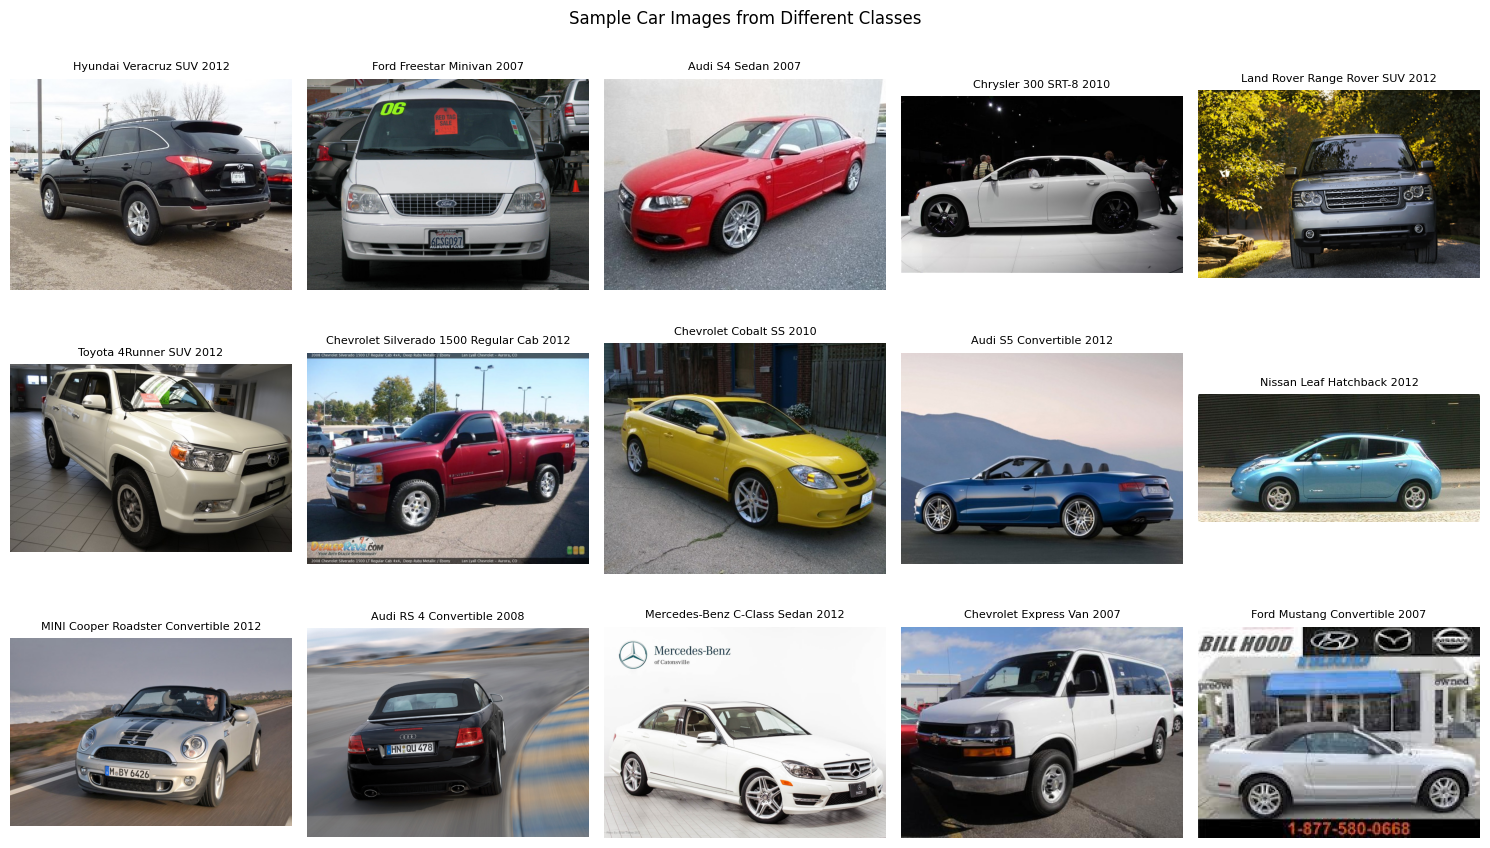

In [42]:
# Visualize sample images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Car Images from Different Classes')

sample_classes = np.random.choice(train_classes, 15, replace=False)

for idx, class_name in enumerate(sample_classes):
    row = idx // 5
    col = idx % 5
    class_path = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if images:
        img_file = np.random.choice(images)
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(class_name, fontsize=8)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [43]:
# Load all training images and create stratified train/validation split

all_image_paths = []
all_class_names = []

for class_folder in sorted(Path(DATASET_PATH).iterdir()):
    if class_folder.is_dir():
        for img_file in sorted(class_folder.glob("*.jpg")) + sorted(class_folder.glob("*.jpeg")) + sorted(class_folder.glob("*.png")):
            all_image_paths.append(str(img_file))
            all_class_names.append(class_folder.name)

# Reuse brand_to_index and num_classes from earlier (already defined)
# Encode labels
labels = np.array([brand_to_index[extract_brand(c)] for c in all_class_names])
all_image_paths = np.array(all_image_paths)

# Stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Brand classes: {num_classes}")

Training samples: 6515
Validation samples: 1629
Brand classes: 49


In [49]:
# Model Architecture Factory

def build_model(model_type, input_shape, num_classes):
    """Build model architecture.
    
    Args:
        model_type: 'custom', 'mobilenet', or 'efficientnet'
        input_shape: Tuple of (height, width, channels)
        num_classes: Number of output classes
    
    Returns:
        Uncompiled Keras model
    """
    if model_type == "custom":
        model = keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])
    elif model_type == "mobilenet":
        base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = False
        model = keras.Sequential([
            layers.Input(shape=input_shape),
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation='softmax')
        ])
    elif model_type == "efficientnet":
        # Disable layout optimizer to avoid NCHW/NHWC conversion errors
        tf.config.optimizer.set_experimental_options({"layout_optimizer": False})
        base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = False
        model = keras.Sequential([
            layers.Input(shape=input_shape),
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation='softmax')
        ])
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    return model


# Training Loop

models_to_train = ["custom", "mobilenet", "efficientnet"]
trained_models = {}
histories = {}
val_metrics = {}
test_metrics = {}
training_times = {}
model_params = {}

for model_type in models_to_train:
    print(f"\nTraining {model_type.upper()}...")
    start_time = time.time()
    
    try:
        # Build datasets with model-specific preprocessing
        train_ds = build_dataset(train_paths, train_labels, model_type, BATCH_SIZE, augment=True)
        val_ds = build_dataset(val_paths, val_labels, model_type, BATCH_SIZE, augment=False)
        
        # Build and compile model
        model = build_model(model_type, (IMG_SIZE, IMG_SIZE, 3), num_classes)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )
        
        # Count parameters
        total_params, trainable_params = count_model_parameters(model)
        model_params[model_type] = {'total': total_params, 'trainable': trainable_params}
        
        # Train model
        history = model.fit(
            train_ds,
            epochs=EPOCHS,
            steps_per_epoch=len(train_paths) // BATCH_SIZE,
            validation_data=val_ds,
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
            ],
            verbose=0
        )
        
        training_times[model_type] = time.time() - start_time
        
        # Evaluate on validation set
        val_results = model.evaluate(val_ds, verbose=0)
        val_loss, val_acc, val_top5 = val_results[0], val_results[1], val_results[2]
        
        # Store results
        trained_models[model_type] = model
        histories[model_type] = history
        val_metrics[model_type] = {'loss': val_loss, 'acc': val_acc, 'top5': val_top5}
        
        # Save model (using .keras format instead of legacy .h5)
        model.save(f"best_model_{model_type}.keras")
        gc.collect()
        
        print(f"  Validation Accuracy: {val_acc:.4f}")
        print(f"  Top-5 Accuracy: {val_top5:.4f}")
        print(f"  Training Time: {training_times[model_type]:.1f}s")
    
    except Exception as e:
        print(f"  ERROR during training: {str(e)}")
        print(f"  Skipping {model_type.upper()} model")
        training_times[model_type] = time.time() - start_time
        continue


Training CUSTOM...
  Validation Accuracy: 0.2014
  Top-5 Accuracy: 0.5365
  Training Time: 1306.8s

Training MOBILENET...
  Validation Accuracy: 0.4831
  Top-5 Accuracy: 0.8115
  Training Time: 777.7s

Training EFFICIENTNET...
  Validation Accuracy: 0.5856
  Top-5 Accuracy: 0.8846
  Training Time: 1038.1s


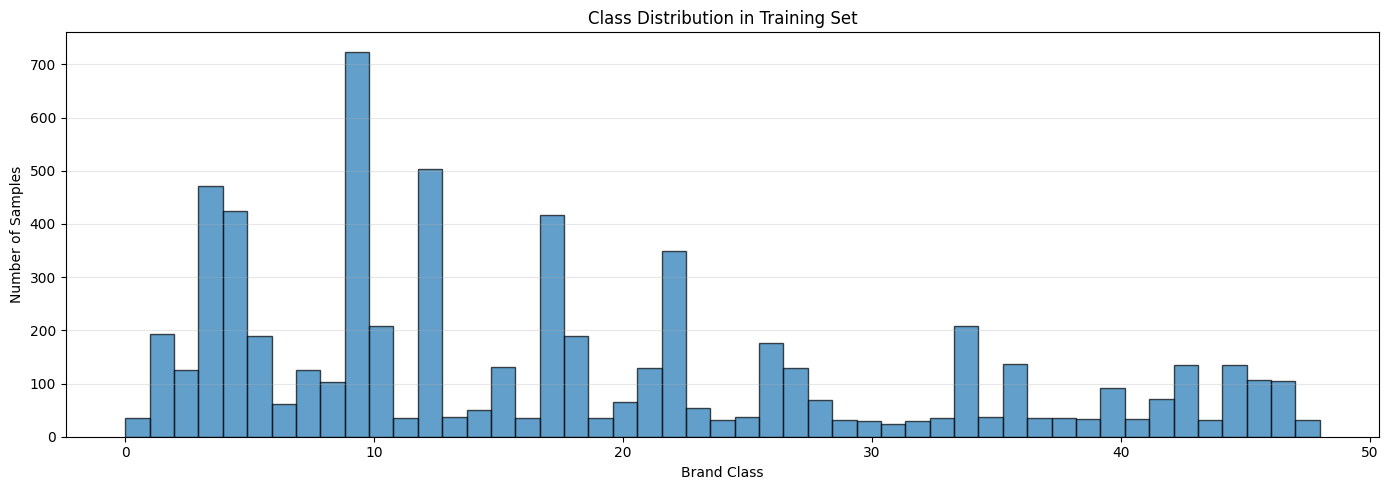


----------------------------------------------------------------------
CLASS IMBALANCE ANALYSIS
----------------------------------------------------------------------
Minimum samples per class: 23
Maximum samples per class: 724
Imbalance ratio (max/min): 31.48
----------------------------------------------------------------------

Validation Metrics (computed)
  CUSTOM: Acc=0.2014, Top-5=0.5365
  MOBILENET: Acc=0.4831, Top-5=0.8115
  EFFICIENTNET: Acc=0.5856, Top-5=0.8846


In [51]:
# Class Imbalance Visualization

fig, ax = plt.subplots(figsize=(14, 5))
ax.hist(train_labels, bins=num_classes, edgecolor='black', alpha=0.7)
ax.set_xlabel('Brand Class')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution in Training Set')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Class Imbalance Statistics

class_counts = Counter(train_labels)
min_class_count = min(class_counts.values())
max_class_count = max(class_counts.values())
imbalance_ratio = max_class_count / min_class_count

print("\n" + "-" * 70)
print("CLASS IMBALANCE ANALYSIS")
print("-" * 70)
print(f"Minimum samples per class: {min_class_count}")
print(f"Maximum samples per class: {max_class_count}")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
print("-" * 70)

# Validation Set Evaluation

val_pred_classes_dict = {}

for model_type in models_to_train:
    val_ds_eval = build_dataset(val_paths, val_labels, model_type, BATCH_SIZE, augment=False)
    
    model = trained_models[model_type]
    val_results = model.evaluate(val_ds_eval, verbose=0)
    val_loss, val_acc, val_top5 = val_results[0], val_results[1], val_results[2]
    
    val_metrics[model_type] = {'loss': val_loss, 'acc': val_acc, 'top5': val_top5}
    
    val_predictions = model.predict(val_ds_eval, verbose=0)
    val_pred_classes_dict[model_type] = np.argmax(val_predictions, axis=1)

print("\nValidation Metrics (computed)")
for model_type in models_to_train:
    print(f"  {model_type.upper()}: Acc={val_metrics[model_type]['acc']:.4f}, "
          f"Top-5={val_metrics[model_type]['top5']:.4f}")

In [52]:
# Load Test Set and Evaluate All Models

# Load test images
test_image_paths = []
test_class_names = []

for class_folder in sorted(Path(TEST_PATH).iterdir()):
    if class_folder.is_dir():
        for img_file in sorted(class_folder.glob("*.jpg")) + sorted(class_folder.glob("*.jpeg")) + sorted(class_folder.glob("*.png")):
            test_image_paths.append(str(img_file))
            test_class_names.append(class_folder.name)

# Convert to brand labels
test_image_labels = np.array([brand_to_index[extract_brand(c)] for c in test_class_names])
test_image_paths = np.array(test_image_paths)

print(f"Test samples: {len(test_image_paths)}")

# Evaluate all models on test set
test_pred_classes_dict = {}

for model_type in models_to_train:
    test_ds_final = build_dataset(test_image_paths, test_image_labels, model_type, BATCH_SIZE, augment=False)
    
    model = trained_models[model_type]
    test_results = model.evaluate(test_ds_final, verbose=0)
    test_loss, test_acc, test_top5 = test_results[0], test_results[1], test_results[2]
    
    test_metrics[model_type] = {'loss': test_loss, 'acc': test_acc, 'top5': test_top5}
    
    test_predictions = model.predict(test_ds_final, verbose=0)
    test_pred_classes_dict[model_type] = np.argmax(test_predictions, axis=1)
    
    print(f"  {model_type.upper()}: Test Acc={test_acc:.4f}, Top-5={test_top5:.4f}")

Test samples: 8041
  CUSTOM: Test Acc=0.1994, Top-5=0.5406
  MOBILENET: Test Acc=0.4905, Top-5=0.8319
  EFFICIENTNET: Test Acc=0.6017, Top-5=0.8944


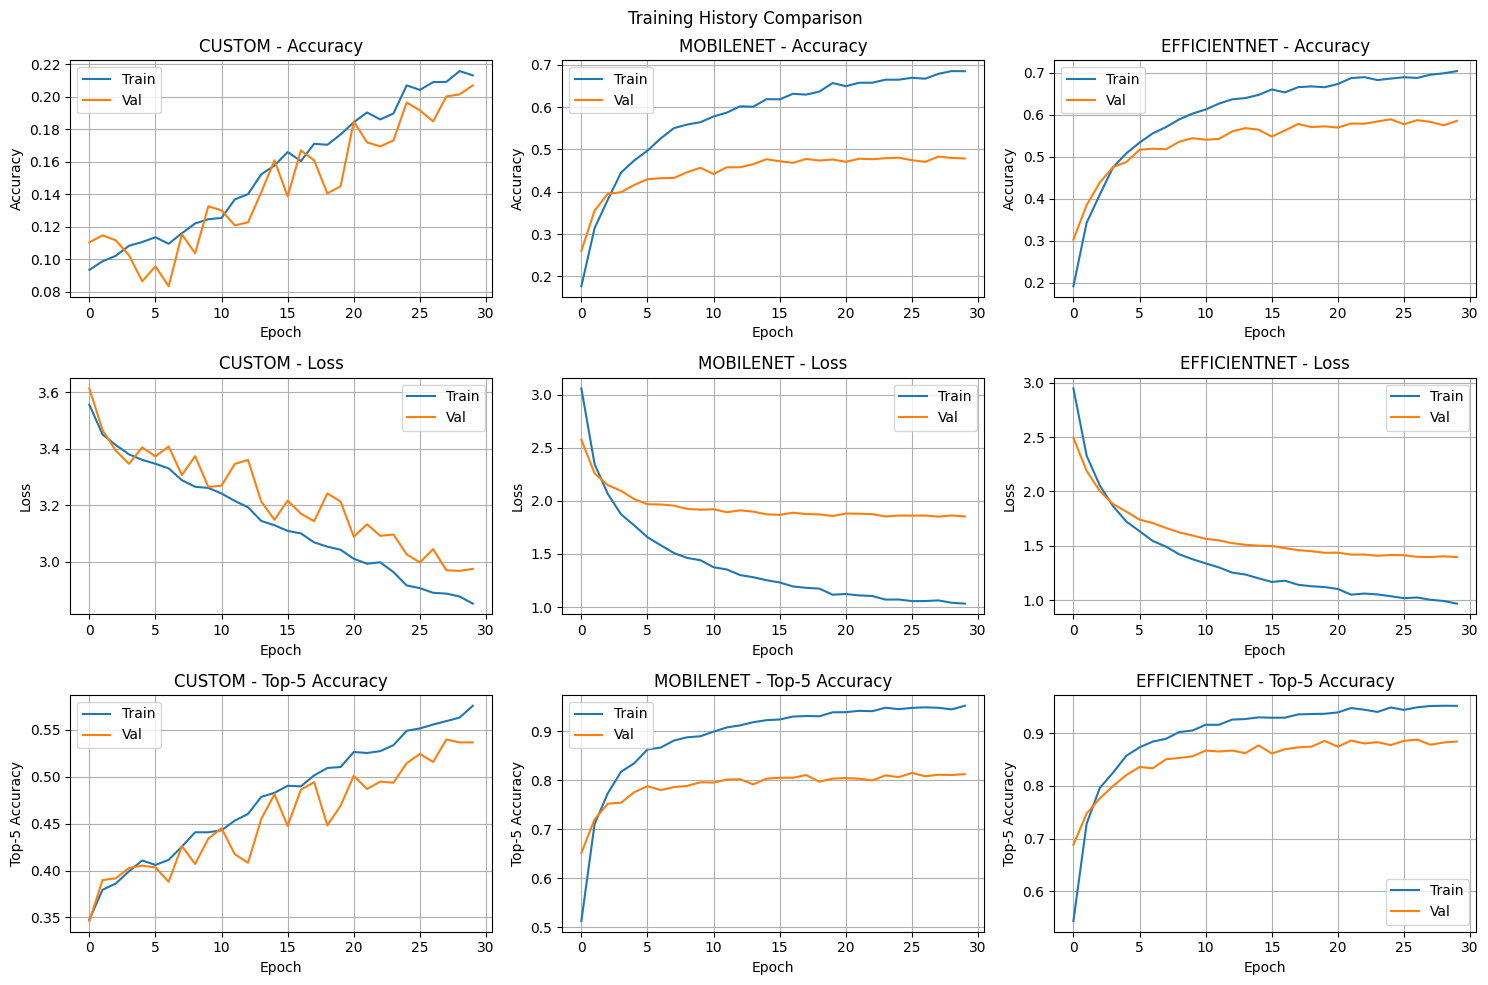

In [53]:
# Training History Visualization

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Training History Comparison')

top_k_key = 'sparse_top_k_categorical_accuracy'
val_top_k_key = 'val_sparse_top_k_categorical_accuracy'

for col_idx, model_type in enumerate(models_to_train):
    history = histories[model_type]
    
    # Accuracy
    axes[0, col_idx].plot(history.history['accuracy'], label='Train')
    axes[0, col_idx].plot(history.history['val_accuracy'], label='Val')
    axes[0, col_idx].set_title(f'{model_type.upper()} - Accuracy')
    axes[0, col_idx].set_xlabel('Epoch')
    axes[0, col_idx].set_ylabel('Accuracy')
    axes[0, col_idx].legend()
    axes[0, col_idx].grid(True)
    
    # Loss
    axes[1, col_idx].plot(history.history['loss'], label='Train')
    axes[1, col_idx].plot(history.history['val_loss'], label='Val')
    axes[1, col_idx].set_title(f'{model_type.upper()} - Loss')
    axes[1, col_idx].set_xlabel('Epoch')
    axes[1, col_idx].set_ylabel('Loss')
    axes[1, col_idx].legend()
    axes[1, col_idx].grid(True)
    
    # Top-5 Accuracy
    axes[2, col_idx].plot(history.history[top_k_key], label='Train')
    axes[2, col_idx].plot(history.history[val_top_k_key], label='Val')
    axes[2, col_idx].set_title(f'{model_type.upper()} - Top-5 Accuracy')
    axes[2, col_idx].set_xlabel('Epoch')
    axes[2, col_idx].set_ylabel('Top-5 Accuracy')
    axes[2, col_idx].legend()
    axes[2, col_idx].grid(True)

plt.tight_layout()
plt.show()


------------------------------------------------------------------------------------------------
MODEL COMPARISON SUMMARY
------------------------------------------------------------------------------------------------
Model              Val Acc   Test Acc   Test Top-5   Macro F1   Weighted F1    Params(M)  Time(s)
------------------------------------------------------------------------------------------------
CUSTOM              0.2014     0.1994       0.5406     0.0878        0.1501         0.14   1306.8
MOBILENET           0.4831     0.4905       0.8319     0.4955        0.4838         2.32    777.7
EFFICIENTNET        0.5856     0.6017       0.8944     0.6088        0.5959         4.11   1038.1
------------------------------------------------------------------------------------------------

GENERALIZATION GAP ANALYSIS
------------------------------------------------------------------------------
CUSTOM          Gap: 0.0020
MOBILENET       Gap: 0.0074
EFFICIENTNET    Gap: 0.0160
--

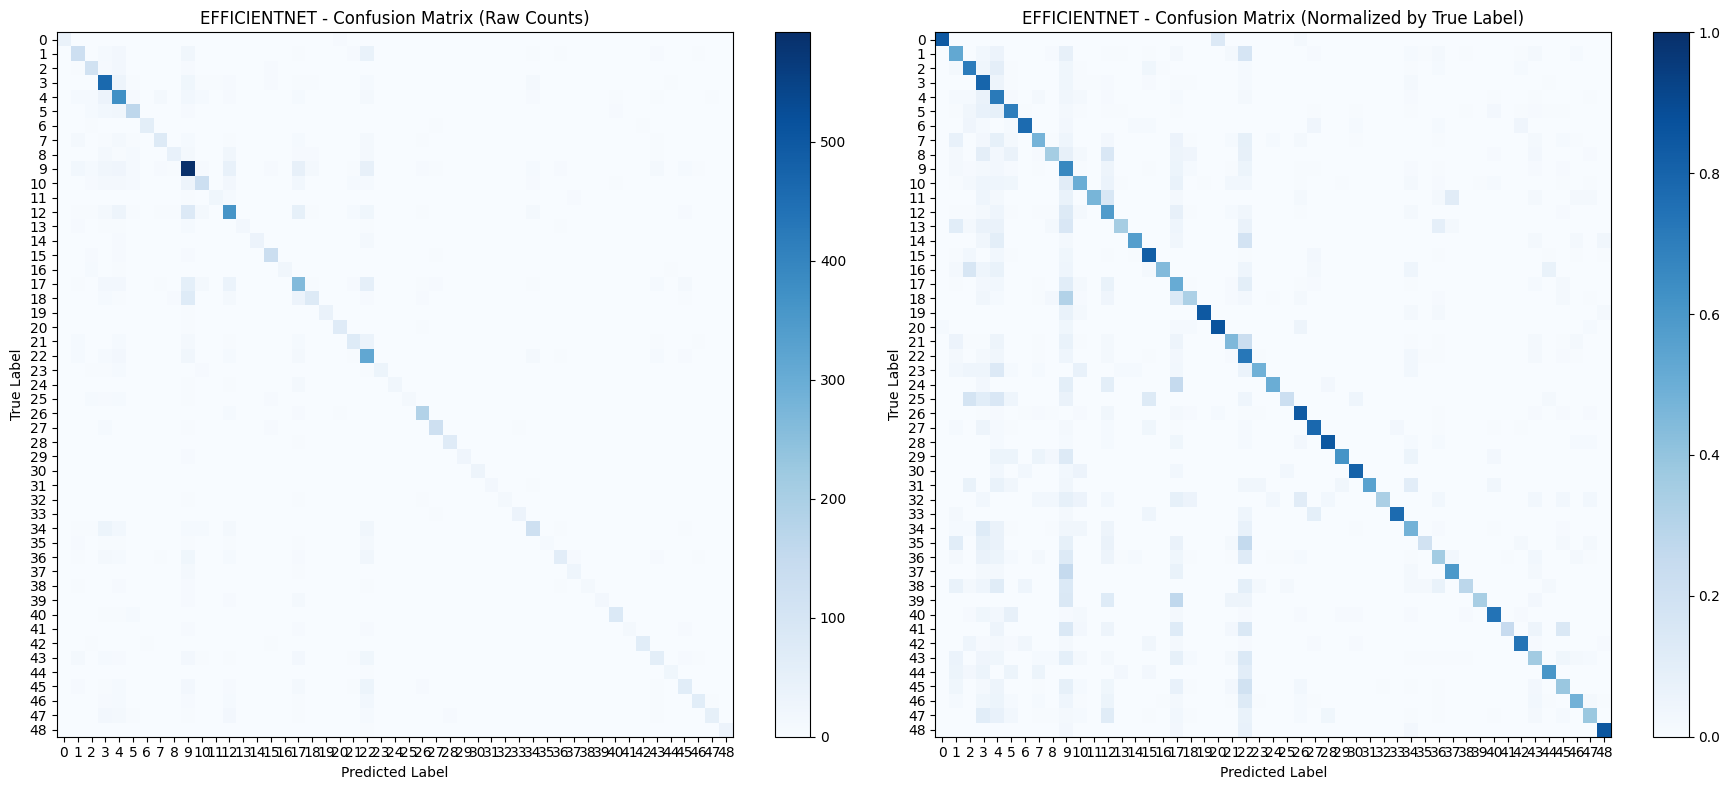


Full confusion matrix visualization complete for EFFICIENTNET


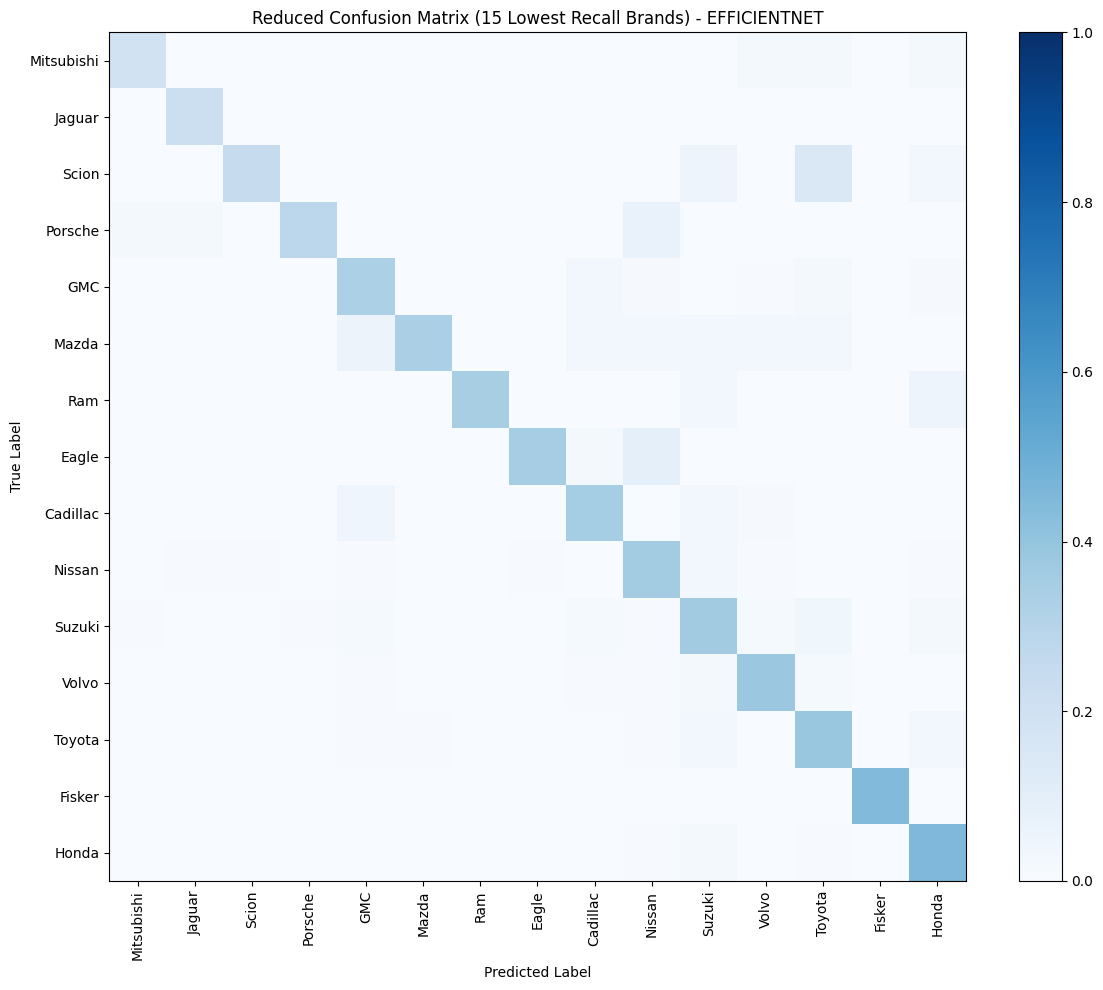


Reduced confusion matrix visualization complete for EFFICIENTNET


In [58]:
# Final Comprehensive Comparison

# Compute metrics for all models on validation set
val_detailed_metrics = {}
for model_type in models_to_train:
    if model_type not in val_pred_classes_dict:
        continue
    val_pred_classes = val_pred_classes_dict[model_type]
    val_metrics_dict = compute_classification_metrics(val_labels, val_pred_classes)
    val_detailed_metrics[model_type] = val_metrics_dict

# Compute metrics for all models on test set
test_detailed_metrics = {}
for model_type in models_to_train:
    if model_type not in test_pred_classes_dict:
        continue
    test_pred_classes = test_pred_classes_dict[model_type]
    test_metrics_dict = compute_classification_metrics(test_image_labels, test_pred_classes)
    test_detailed_metrics[model_type] = test_metrics_dict

# Create comparison data (for reference if needed)
comparison_data = []
for model_type in models_to_train:
    if model_type not in model_params:
        continue
    
    if model_type not in val_metrics or model_type not in test_metrics:
        continue
    
    total_params = int(model_params[model_type]['total'])
    trainable_params = int(model_params[model_type]['trainable'])
    
    comparison_data.append({
        'Model': model_type.upper(),
        'Val Acc': f"{val_metrics[model_type]['acc']:.4f}",
        'Test Acc': f"{test_metrics[model_type]['acc']:.4f}",
        'Val F1': f"{val_detailed_metrics[model_type]['f1_macro']:.4f}" if model_type in val_detailed_metrics else 'N/A',
        'Test F1': f"{test_detailed_metrics[model_type]['f1_macro']:.4f}" if model_type in test_detailed_metrics else 'N/A',
        'Total Params': f"{total_params:,}",
        'Trainable Params': f"{trainable_params:,}",
        'Training Time': f"{training_times[model_type]:.1f}s"
    })

# Print Professional Comparison Summary

print("\n" + "-" * 96)
print("MODEL COMPARISON SUMMARY")
print("-" * 96)
print(f"{'Model':<15} {'Val Acc':>10} {'Test Acc':>10} {'Test Top-5':>12} {'Macro F1':>10} {'Weighted F1':>13} {'Params(M)':>12} {'Time(s)':>8}")
print("-" * 96)

for model_type in models_to_train:
    if model_type not in model_params or model_type not in val_metrics or model_type not in test_metrics:
        continue
    
    val_acc = val_metrics[model_type]['acc']
    test_acc = test_metrics[model_type]['acc']
    test_top5 = test_metrics[model_type]['top5']
    test_f1 = test_detailed_metrics[model_type]['f1_macro'] if model_type in test_detailed_metrics else 0.0
    test_f1_weighted = test_detailed_metrics[model_type]['f1_weighted'] if model_type in test_detailed_metrics else 0.0
    total_params_m = int(model_params[model_type]['total']) / 1e6
    train_time = training_times[model_type]
    
    print(f"{model_type.upper():<15} {val_acc:>10.4f} {test_acc:>10.4f} {test_top5:>12.4f} {test_f1:>10.4f} {test_f1_weighted:>13.4f} {total_params_m:>12.2f} {train_time:>8.1f}")

print("-" * 96)

# Generalization Gap Analysis

print("\nGENERALIZATION GAP ANALYSIS")
print("-" * 78)

for model_type in models_to_train:
    if model_type not in model_params or model_type not in val_metrics or model_type not in test_metrics:
        continue
    
    val_acc = val_metrics[model_type]['acc']
    test_acc = test_metrics[model_type]['acc']
    gap = abs(test_acc - val_acc)
    
    print(f"{model_type.upper():<15} Gap: {gap:.4f}")

print("-" * 78)
print("Generalization gaps < 0.02 indicate stable performance.")
print("-" * 78)

# ============================================================================
# CONFUSION MATRICES - TEST SET ANALYSIS
# ============================================================================

if "efficientnet" in trained_models:
    best_model_type = "efficientnet"
elif "mobilenet" in trained_models:
    best_model_type = "mobilenet"
else:
    best_model_type = "custom"

print(f"\nUsing {best_model_type.upper()} for confusion matrix analysis...")

test_pred_classes = test_pred_classes_dict[best_model_type]

cm = confusion_matrix(test_image_labels, test_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Confusion Pair Analysis

# Extract off-diagonal confusion pairs
confusion_pairs = []
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        if i != j and cm_normalized[i, j] > 0:  # Ignore diagonal and zeros
            confusion_pairs.append((i, j, cm_normalized[i, j]))

# Sort by confusion rate
confusion_pairs_sorted = sorted(confusion_pairs, key=lambda x: x[2], reverse=True)

# Top 10 Most Confused Pairs
print("\nTOP 10 MOST CONFUSED BRAND PAIRS (True → Predicted)")
print("-" * 60)
for i in range(min(10, len(confusion_pairs_sorted))):
    true_idx, pred_idx, rate = confusion_pairs_sorted[i]
    print(f"{brands[true_idx]} → {brands[pred_idx]} : {rate:.4f}")

print()

# Full Confusion Matrix Visualization (Appendix Figure)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Raw confusion matrix
im0 = axes[0].imshow(cm, cmap='Blues', aspect='auto')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title(f'{best_model_type.upper()} - Confusion Matrix (Raw Counts)')
axes[0].set_xticks(np.arange(num_classes))
axes[0].set_yticks(np.arange(num_classes))
plt.colorbar(im0, ax=axes[0])

# Normalized confusion matrix
im1 = axes[1].imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title(f'{best_model_type.upper()} - Confusion Matrix (Normalized by True Label)')
axes[1].set_xticks(np.arange(num_classes))
axes[1].set_yticks(np.arange(num_classes))
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\nFull confusion matrix visualization complete for {best_model_type.upper()}")

# Reduced Confusion Matrix for Worst Performing Classes

# Compute per-class recall (diagonal of normalized confusion matrix)
per_class_recall = np.diag(cm_normalized)

# Find indices of 15 brands with lowest recall
worst_brand_indices = np.argsort(per_class_recall)[:15]
worst_brand_names = [brands[i] for i in worst_brand_indices]

# Extract 15×15 submatrix
cm_reduced = cm_normalized[np.ix_(worst_brand_indices, worst_brand_indices)]

# Plot reduced confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm_reduced, cmap='Blues', aspect='auto', vmin=0, vmax=1)

# Set tick labels to brand names
ax.set_xticks(np.arange(len(worst_brand_names)))
ax.set_yticks(np.arange(len(worst_brand_names)))
ax.set_xticklabels(worst_brand_names, rotation=90, ha='center')
ax.set_yticklabels(worst_brand_names)

# Labels and title
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Reduced Confusion Matrix (15 Lowest Recall Brands) - {best_model_type.upper()}')

# Add colorbar
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print(f"\nReduced confusion matrix visualization complete for {best_model_type.upper()}")